In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


label     0
review    0
dtype: int64


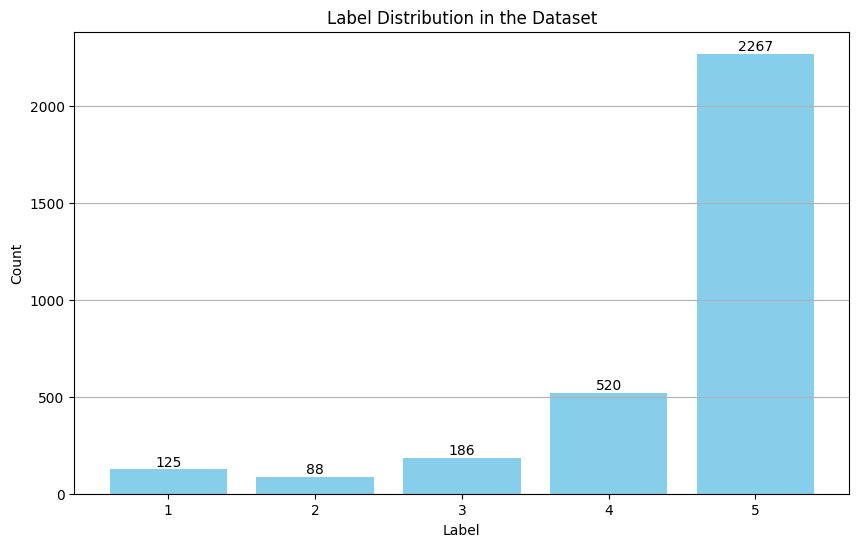

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

FILE = '/content/drive/MyDrive/Colab Notebooks/BERT_YH/momo_reviews_input.csv'
df = pd.read_csv(FILE)
print(df.isnull().sum())

# Drop rows with NaN values in 'review' or 'label' columns
df.dropna(subset=['review', 'label'], inplace=True)

# Count the occurrences of each label
label_counts = df['label'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in the Dataset')
plt.xticks(label_counts.index)
plt.grid(axis='y')

# Annotate the counts on top of the bars
for index, value in enumerate(label_counts.values):
    plt.text(label_counts.index[index], value, str(value), ha='center', va='bottom')

plt.show()


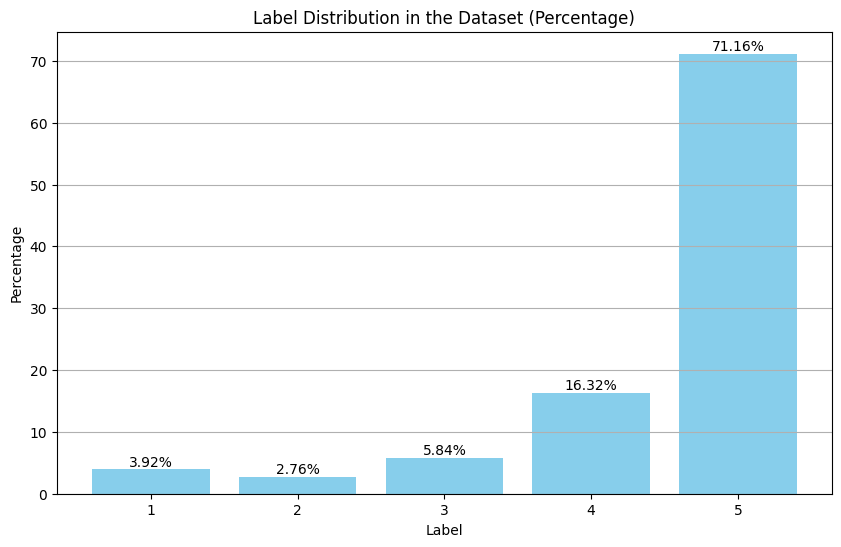

In [ ]:
# Calculate percentages
label_percentages = (label_counts / label_counts.sum()) * 100

plt.figure(figsize=(10, 6))
plt.bar(label_percentages.index, label_percentages.values, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.title('Label Distribution in the Dataset (Percentage)')
plt.xticks(label_percentages.index)
plt.grid(axis='y')

# Annotate the percentages on top of the bars
for index, value in enumerate(label_percentages.values):
  plt.text(label_percentages.index[index], value, f'{value:.2f}%', ha='center', va='bottom')

plt.show()


In [ ]:
!pip install torch
!pip install transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
pip install accelerate -U scikit-learn demoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1


In [ ]:
import demoji
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import os
import yaml
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from sklearn.metrics import f1_score
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import re
from sklearn.utils import resample

# Initialize demoji
demoji.download_codes()

<ipython-input-4-1c9fe64f2171>:23: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
# Define device
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device:', device)

Device: cuda


In [ ]:
# Set environment variable for CUDA debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
FILE = '/content/drive/MyDrive/Colab Notebooks/BERT_YH/momo_reviews_input.csv'
df = pd.read_csv(FILE)
print(df.isnull().sum())

# Drop rows with NaN values in 'review' or 'label' columns
df.dropna(subset=['review', 'label'], inplace=True)

label     0
review    0
dtype: int64


In [ ]:
df['label'] = df['label'].astype(int)
# X = df['review']
df['label'] = df['label'] // 3


# Separate majority and minority classes
df_majority = df[df.label == 1]
df_minority = df[df.label == 0]

# print(df['label'].value_counts())

# Upsample minority class
df_minority_upsampled = resample(df_minority,
  replace=True,  # sample with replacement
  n_samples=len(df_majority),  # to match majority class
  random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Display new class distribution
print(df_balanced['label'].value_counts())

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced)

label
1    2973
0    2973
Name: count, dtype: int64
      label                                             review
0         1        服務很好，師傅很專業，但是建議去裝前，一定要跟師傅確定好價格方面，才不會有不必要糾紛😑
1         0  6月24日下午裝機,晚上就不動了,25日來看過說要更換室外機,可是今天27日了還不見人影.遇...
2         1                         預約安裝快速，施工前溝通詳細，工班施工細心，值得推薦
3         0  冷氣安裝後未完成試機程序，安裝冷氣廠商並未請採購主家人陪同檢驗試機過程就離開，導致採購主下班...
4         0  6/19下單，6／25裝機，結果新品不良，不能遙控溫度及開關機，只能拔電源線，至今原廠沒聯絡...
...     ...                                                ...
5941      0  到貨後，靜置135分後開機，插電約5分鐘後停機，完全無作用，完全無法使用.現在天氣熱，急需使...
5942      0                        11坪客廳不會冷⋯5坪大房間也不會冷⋯只有對著人吹會冷
5943      0                        貨送到了,但要你加價9千元,才能安裝,決定不裝了,殘念
5944      0                                          安裝收費非常不合理
5945      1                          今天訂,隔天就到貨了,吹起來有涼,目前使用上很滿意

[5946 rows x 2 columns]


In [ ]:
X = df_balanced['review']
y = df_balanced['label']

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

In [ ]:
PRETRAINED_MODEL_NAME = 'bert-base-chinese'

params = {
  'learning_rate': [1e-5],
  'per_device_batch_size': [32],
  'num_train_epochs': [4],
  'weight_decay': [0.01],
  'warmup_steps': [500],
  'dropout_rate': [0.3],
  'hidden_dim': [768],
  'max_length': [512]
}

grid = ParameterGrid(params)

def save_hyperparameters(params, file_path='/content/drive/MyDrive/Colab Notebooks/BERT_YH/hyperparams.yaml'):
  with open(file_path, 'w') as f:
    yaml.dump(params, f)

def load_hyperparameters(file_path='/content/drive/MyDrive/Colab Notebooks/BERT_YH/hyperparams.yaml'):
  with open(file_path, 'r') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
  return params


In [ ]:
class BertSentimentClassifier(nn.Module):
  # def __init__(self, pretrained_model_name, params, class_weights=class_weights):
  def __init__(self, pretrained_model_name, params):
    super(BertSentimentClassifier, self).__init__()
    self.params = params
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
    self.bert = BertForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2).bert
    # self.class_weights = class_weights
    self.dropout = nn.Dropout(params['dropout_rate'])
    self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    # self.criterion = nn.CrossEntropyLoss(weight=class_weights)
    self.criterion = nn.CrossEntropyLoss()

    self.optimizer = AdamW(self.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    self.scheduler = None
    self.to(self.device)  # Move the whole model to the device


  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs[1]
    x = self.dropout(pooled_output)
    logits = self.classifier(x)
    return logits

  def preprocess_text(self, text):
    return demoji.replace_with_desc(text)

  def tokenize_data(self, reviews):
    processed_reviews = [self.preprocess_text(review) for review in reviews]
    return self.tokenizer(processed_reviews, padding=True, truncation=True, max_length=self.params['max_length'], return_tensors='pt')

  def prepare_data(self, X_train, y_train, X_val, y_val):
    train_encodings = self.tokenize_data(X_train)
    val_encodings = self.tokenize_data(X_val)

    train_dataset = ReviewsDataset(train_encodings, y_train, self.device)
    val_dataset = ReviewsDataset(val_encodings, y_val, self.device)

    self.train_loader = DataLoader(train_dataset, batch_size=self.params['per_device_batch_size'], shuffle=True)
    self.val_loader = DataLoader(val_dataset, batch_size=self.params['per_device_batch_size'], shuffle=False)
    self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=self.params['warmup_steps'], num_training_steps=len(self.train_loader) * self.params['num_train_epochs'])


  def calculate_accuracy(self, preds, labels):
    _, pred_labels = torch.max(preds, 1)
    correct = (pred_labels == labels).sum().item()
    return correct / len(labels)

  def calculate_f1(self, preds, labels):
    _, pred_labels = torch.max(preds, 1)
    return f1_score(labels.cpu().numpy(), pred_labels.cpu().numpy(), average='weighted')

  def train_model(self, num_epochs):
    self.train()
    epoch_losses = []
    epoch_accuracies = []
    epoch_f1_scores = []
    epoch_val_losses = []
    epoch_val_accuracies = []
    epoch_val_f1_scores = []

    for epoch in range(num_epochs):
      epoch_loss = 0
      epoch_accuracy = 0
      epoch_f1 = 0
      for batch in self.train_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        self.optimizer.zero_grad()
        logits = self.forward(input_ids, attention_mask)
        loss = self.criterion(logits, labels)

        loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.scheduler.step()

        epoch_loss += loss.item()
        epoch_accuracy += self.calculate_accuracy(logits, labels)
        epoch_f1 += self.calculate_f1(logits, labels)

      epoch_loss /= len(self.train_loader)
      epoch_accuracy /= len(self.train_loader)
      epoch_losses.append(epoch_loss)
      epoch_accuracies.append(epoch_accuracy)
      epoch_f1 /= len(self.train_loader)
      epoch_f1_scores.append(epoch_f1)

      val_loss, val_accuracy, val_f1 = self.evaluate()
      epoch_val_losses.append(val_loss)
      epoch_val_accuracies.append(val_accuracy)
      epoch_val_f1_scores.append(val_f1)

      print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}, Training F1 Score: {epoch_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}')

    print('Training finished.')
    return epoch_losses, epoch_accuracies, epoch_f1_scores, epoch_val_losses, epoch_val_accuracies, epoch_val_f1_scores

  def evaluate(self):
    self.eval()
    val_loss = 0
    val_accuracy = 0
    val_f1 = 0
    with torch.no_grad():
      for batch in self.val_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self.forward(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        val_loss += loss.item()
        val_accuracy += self.calculate_accuracy(logits, labels)
        val_f1 += self.calculate_f1(logits, labels)

    val_loss /= len(self.val_loader)
    val_accuracy /= len(self.val_loader)
    val_f1 /= len(self.val_loader)
    return val_loss, val_accuracy, val_f1

In [ ]:
class ReviewsDataset(Dataset):
  def __init__(self, encodings, labels=None, device=None):
    self.encodings = encodings
    self.labels = labels
    self.device = device

  def __len__(self):
    return len(self.encodings['input_ids'])

  def __getitem__(self, idx):
    item = {key: val[idx].to(self.device) for key, val in self.encodings.items()}
    if self.labels is not None:
      item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long).to(self.device)
    return item

In [ ]:
def plot_training(all_fold_losses, all_fold_accuracies, all_fold_f1_scores, file_path):
  epochs = list(range(1, len(all_fold_losses[0]) + 1))

  avg_losses = np.mean(all_fold_losses, axis=0)
  avg_accuracies = np.mean(all_fold_accuracies, axis=0)
  avg_f1_scores = np.mean(all_fold_f1_scores, axis=0)

  plt.figure(figsize=(18, 6))
  plt.subplot(1, 3, 1)
  plt.plot(epochs, avg_losses, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss per Epoch')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(epochs, avg_accuracies, label='Training Accuracy', color='orange')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy per Epoch')
  plt.legend()

  plt.subplot(1, 3, 3)
  plt.plot(epochs, avg_f1_scores, label='Training F1 Score', color='green')
  plt.xlabel('Epoch')
  plt.ylabel('F1 Score')
  plt.title('Training F1 Score per Epoch')
  plt.legend()

  plt.tight_layout()
  plt.savefig(file_path)

In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, plot_file_path):
  epochs = list(range(1, len(train_losses) + 1))

  plt.figure(figsize=(12, 8))

  # Plotting Loss
  plt.subplot(2, 1, 1)
  plt.plot(epochs, train_losses, 'o-', label='Train Loss')
  plt.plot(epochs, val_losses, 'o-', label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  # Plotting Accuracy
  plt.subplot(2, 1, 2)
  plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
  plt.plot(epochs, val_accuracies, 'o-', label='Val Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.savefig(plot_file_path)

In [ ]:
def send_email(hyperparameters, training_summary, plot_file_path, additional_plot_file_path, to_email):
  from_email = ""
  app_password = ""

  msg = MIMEMultipart()
  msg['From'] = from_email
  msg['To'] = to_email
  msg['Subject'] = "Training Summary - BERT BinaryOversample"

  body = f"Hyperparameters:\n{hyperparameters}\n\nTraining Summary:\n{training_summary}"
  msg.attach(MIMEText(body, 'plain'))

  with open(plot_file_path, "rb") as attachment:
    part = MIMEBase("application", "octet-stream")
    part.set_payload(attachment.read())
    encoders.encode_base64(part)
    part.add_header("Content-Disposition", f"attachment; filename= {plot_file_path}",)
    msg.attach(part)

  with open(additional_plot_file_path, "rb") as attachment:
    part = MIMEBase("application", "octet-stream")
    part.set_payload(attachment.read())
    encoders.encode_base64(part)
    part.add_header("Content-Disposition", f"attachment; filename= {additional_plot_file_path}",)
    msg.attach(part)

  try:
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(from_email, app_password)
    text = msg.as_string()
    server.sendmail(from_email, to_email, text)
    server.quit()
    print("Email sent successfully.")
  except smtplib.SMTPAuthenticationError as e:
    print(f"SMTPAuthenticationError: {e}")
  except Exception as e:
    print(f"Error: {e}")

In [ ]:
def train_and_evaluate_model(params):
  all_fold_losses = []
  all_fold_accuracies = []
  all_fold_f1_scores = []
  training_summaries = []

  for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}/{n_splits}')

    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    classifier = BertSentimentClassifier(PRETRAINED_MODEL_NAME, params)
    classifier.prepare_data(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

    epoch_losses, epoch_accuracies, epoch_f1_scores, epoch_val_losses, epoch_val_accuracies, epoch_val_f1_scores = classifier.train_model(params['num_train_epochs'])

    all_fold_losses.append(epoch_losses)
    all_fold_accuracies.append(epoch_accuracies)
    all_fold_f1_scores.append(epoch_f1_scores)

    val_loss, val_accuracy, val_f1 = classifier.evaluate()
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}')
    fold_summary = (
      f"Fold {fold + 1}/{n_splits}\n"
      + "\n".join([
        f"Epoch {i + 1}: Training Loss: {loss:.4f}, Training Accuracy: {accuracy:.4f}, Training F1 Score: {f1:.4f}, "
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}"
        for i, (loss, accuracy, f1, val_loss, val_accuracy, val_f1) in enumerate(zip(epoch_losses, epoch_accuracies, epoch_f1_scores, epoch_val_losses, epoch_val_accuracies, epoch_val_f1_scores))
      ])
      + f"\nFinal Validation Loss: {epoch_val_losses[-1]:.4f}, Final Validation Accuracy: {epoch_val_accuracies[-1]:.4f}, Final Validation F1 Score: {epoch_val_f1_scores[-1]:.4f}\n"
    )
    training_summaries.append(fold_summary)

  return all_fold_losses, all_fold_accuracies, all_fold_f1_scores, training_summaries


In [ ]:
# for params in grid:
#   print(f"Training with parameters: {params}")
#   save_hyperparameters(params)  # Save the current hyperparameters

#   all_fold_losses, all_fold_accuracies, all_fold_f1_scores, training_summaries = train_and_evaluate_model(params)

#   # Generate and save the combined plot
#   plot_file_path = f"/content/drive/MyDrive/Colab Notebooks/BERT_YH/grid_training_plot_{params['learning_rate']}_{params['per_device_batch_size']}.png"
#   plot_training(all_fold_losses, all_fold_accuracies, all_fold_f1_scores, plot_file_path)

#   # Generate and save the additional metrics plot
#   additional_plot_file_path = f"/content/drive/MyDrive/Colab Notebooks/BERT_YH/additional_plot_{params['learning_rate']}_{params['per_device_batch_size']}.png"
#   plot_metrics(
#     np.mean([fold for fold in all_fold_losses], axis=0),
#     np.mean([fold for fold in all_fold_f1_scores], axis=0),
#     np.mean([fold for fold in all_fold_accuracies], axis=0),
#     np.mean([fold for fold in all_fold_f1_scores], axis=0),
#     additional_plot_file_path
#   )

#   # Prepare the email content
#   training_summary = "\n".join(training_summaries)
#   hyperparameters_str = yaml.dump(params)  # Convert params to string

#   send_email(
#     hyperparameters=hyperparameters_str,
#     training_summary=training_summary,
#     plot_file_path=plot_file_path,
#     additional_plot_file_path=additional_plot_file_path,
#     to_email=""
#   )

In [ ]:
# # Save the model

# model = BertSentimentClassifier(PRETRAINED_MODEL_NAME, params)
# model_path = '/content/drive/MyDrive/Colab Notebooks/BERT_YH/BERT_YH.pth'
# torch.save(model.state_dict(), model_path)
# print(f'Model saved to {model_path}')


In [ ]:
pip install cchardet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 41.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cchardet: filename=cchardet-2.1.7-cp310-cp310-linux_x86_64.whl size=289400 sha256=93421455a7566cd371b9a36a56eee98e246e2c2587bd790d23f46fe8a133cea5
  Stored in directory: /root/.cache/pip/wheels/ee/e0/ab/e01326f15c59438d080b1496dbab8091e952ec72f35e3c437e
Successfully built cchardet


In [ ]:
MOBILE_FINAL = '/content/drive/MyDrive/Colab Notebooks/BERT_YH/Copy of 整理_715.xlsx'

mobile_raw = pd.read_excel(MOBILE_FINAL, '整理_715')
mobile01_brands = mobile_raw['brand']

In [ ]:
patterns = [' ', '--', '。', '.', '，', ',', '、', '！', '!', '？', '?', '「', '」', '『', '』', ')', '(', ';', ':', '*', '~', '～', '_', "'", '"']
pattern = '|'.join(map(re.escape, patterns))
mobile01_reviews = mobile_raw['comment'].str.replace(pattern, ' ', regex=True)

In [ ]:
import torch
import demoji
from transformers import BertTokenizer
import torch.nn.functional as F


class BertSentimentPredictor:
  def __init__(self, model, tokenizer):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.tokenizer = tokenizer
    self.model = model.to(self.device)
    self.model.eval()

  def preprocess_text(self, text):
    return demoji.replace_with_desc(text)

  def predict(self, review, brand):
    combined_text = f"品牌: {brand} 評論: {review}"
    processed_text = self.preprocess_text(combined_text)
    inputs = self.tokenizer(processed_text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Removing 'token_type_ids' from inputs if present
    inputs.pop('token_type_ids', None)
    inputs = {key: val.to(self.device) for key, val in inputs.items()}

    with torch.no_grad():
      logits = self.model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
      probabilities = F.softmax(logits, dim=1)
      predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities.cpu().numpy()

model_path = "/content/drive/MyDrive/Colab Notebooks/BERT_YH/BERT_YH.pth"
params = {
  'learning_rate': 1e-5,
  'per_device_batch_size': 32,
  'num_train_epochs': 4,
  'weight_decay': 0.01,
  'warmup_steps': 500,
  'dropout_rate': 0.3,
  'hidden_dim': 768,
  'max_length': 512
}

pretrained_model_name = 'bert-base-chinese'

classifier = BertSentimentClassifier(pretrained_model_name, params)
classifier.load_state_dict(torch.load(model_path), strict=False)


tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
predictor = BertSentimentPredictor(model=classifier, tokenizer=tokenizer)

mobile01_results = []
for review, brand in zip(mobile01_reviews, mobile01_brands):
  predicted_class, probabilities = predictor.predict(review, brand)
  mobile01_results.append({
    'Brand': brand,
    'Predicted Class': predicted_class,
    # 'Manual Verification': '',
    'Review': review,
    # 'Probabilities': probabilities
  })

mobile01_df = pd.DataFrame(mobile01_results)


print(mobile01_df.head())



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


       Brand  Predicted Class  \
0  PANASONIC                1   
1    HITACHI                1   
2    HITACHI                1   
3         LG                0   
4    HITACHI                0   

                                              Review  
0                                       國際牌的還不錯 後悔沒買  
1                                           後悔沒買其他品牌  
2  我家是裝日立尊榮 遙控器會亮燈提醒我要清洗冷氣啟動一次來維持冷氣內部的清潔這樣冷氣壽命才會長...  
3                 像LG旗艦機種除了有自體清淨的功能 也有奈米離子 可以降低過敏的狀況  
4          日立的凍結洗淨清洗的比較紮實 會運轉25分鐘左右才清洗完畢所以要買的話要選對台喔   


In [ ]:
mobile01_df.to_csv('/content/drive/MyDrive/Colab Notebooks/BERT_YH/mobile_predict.csv', index=False)


In [ ]:
# Group by brand and calculate the sum of prediction scores for each brand
sum_prediction_scores = mobile01_df.groupby('Brand')['Predicted Class'].sum()
# print(sum_prediction_scores)

# Count the number of rows for each brand
brand_counts = mobile01_df['Brand'].value_counts()
# print(brand_counts)

# Divide the sum of prediction scores by the number of rows for each brand to get the average prediction score
average_prediction_scores = sum_prediction_scores / brand_counts
average_prediction_scores = average_prediction_scores.round(4)

# Create a new DataFrame with the results
mobile_predict = pd.DataFrame({
    'sum_prediction_scores': sum_prediction_scores,
    'count': brand_counts,
    'average_prediction_scores': average_prediction_scores
})

print(mobile_predict)

              sum_prediction_scores  count  average_prediction_scores
Brand                                                                
APTON                             1      1                     1.0000
AUX                              27     34                     0.7941
BD                               22     25                     0.8800
CARRIER                           4      4                     1.0000
CHIMEI                           15     18                     0.8333
DAIKIN                          265    324                     0.8179
FUJITSU                          53     56                     0.9464
GREE                             17     19                     0.8947
HAIER                             2      2                     1.0000
HAWRIN                            9     10                     0.9000
HERAN                            28     35                     0.8000
HITACHI                         146    174                     0.8391
KOLIN               

In [ ]:
mobile_predict.to_csv('/content/drive/MyDrive/Colab Notebooks/BERT_YH/mobile_brand_prediction.csv')
